<a href="https://colab.research.google.com/github/rand-albej/cards_cnn/blob/main/cards_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Can you classify cards?
#### We expect you to use card images with their labels to classify unseen test images. You have to write a dataloader to read images from the folder 'cards/', write a CNN class, a loss function, a training loop, and check your test accuracy.

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import imageio as Image
from torchvision.utils import make_grid
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
import pandas as pd

### Nothing to change here (This cell downloads and unzips the data in the folder 'cards/').

In [ ]:
!wget https://www.dropbox.com/s/gxcflnuuq0a64wx/cards.zip

!unzip cards.zip

!ls

Streaming output truncated to the last 5000 lines.
  inflating: __MACOSX/cards/train_cards/._2543.jpg  
  inflating: cards/train_cards/2225.jpg  
  inflating: __MACOSX/cards/train_cards/._2225.jpg  
  inflating: cards/train_cards/4654.jpg  
  inflating: __MACOSX/cards/train_cards/._4654.jpg  
  inflating: cards/train_cards/6043.jpg  
  inflating: __MACOSX/cards/train_cards/._6043.jpg  
  inflating: cards/train_cards/253.jpg  
  inflating: __MACOSX/cards/train_cards/._253.jpg  
  inflating: cards/train_cards/4867.jpg  
  inflating: __MACOSX/cards/train_cards/._4867.jpg  
  inflating: cards/train_cards/6916.jpg  
  inflating: __MACOSX/cards/train_cards/._6916.jpg  
  inflating: cards/train_cards/535.jpg  
  inflating: __MACOSX/cards/train_cards/._535.jpg  
  inflating: cards/train_cards/6902.jpg  
  inflating: __MACOSX/cards/train_cards/._6902.jpg  
  inflating: cards/train_cards/521.jpg  
  inflating: __MACOSX/cards/train_cards/._521.jpg  
  inflating: cards/train_cards/4873.jpg  
  inf

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


### Dataloader
#####  Training and testing data sets are given in the folder 'cards/'. The training data is given as a folder of jpg images and a csv file that contain the class names associated with every image file. The testing data is also given in the same way. The class names can be turned into integer labels using the python dictionary below.

In [ ]:
C = 53  # number of classes
class_names = ['ace of spades', 'seven of clubs', 'jack of clubs', 'two of clubs', 'queen of hearts',
               'two of hearts', 'four of diamonds', 'queen of clubs', 'ten of spades', 'eight of diamonds',
               'three of clubs', 'eight of hearts', 'three of diamonds', 'five of hearts', 'six of clubs',
               'ten of diamonds', 'nine of clubs', 'ten of hearts', 'six of diamonds', 'king of diamonds',
               'nine of hearts', 'eight of clubs', 'seven of hearts', 'five of spades', 'five of diamonds',
               'four of hearts', 'queen of spades', 'four of spades', 'king of hearts', 'jack of spades',
               'seven of diamonds', 'three of spades', 'jack of diamonds', 'six of spades', 'ace of hearts',
               'king of clubs', 'nine of diamonds', 'ace of diamonds', 'eight of spades', 'nine of spades',
               'queen of diamonds', 'jack of hearts', 'joker', 'two of diamonds', 'ten of clubs', 'seven of spades',
               'two of spades', 'five of clubs', 'ace of clubs', 'six of hearts', 'king of spades', 'four of clubs',
               'three of hearts']
names_to_labels = dict(zip(class_names, list(range(C))))

In [ ]:
print(names_to_labels)

{'ace of spades': 0, 'seven of clubs': 1, 'jack of clubs': 2, 'two of clubs': 3, 'queen of hearts': 4, 'two of hearts': 5, 'four of diamonds': 6, 'queen of clubs': 7, 'ten of spades': 8, 'eight of diamonds': 9, 'three of clubs': 10, 'eight of hearts': 11, 'three of diamonds': 12, 'five of hearts': 13, 'six of clubs': 14, 'ten of diamonds': 15, 'nine of clubs': 16, 'ten of hearts': 17, 'six of diamonds': 18, 'king of diamonds': 19, 'nine of hearts': 20, 'eight of clubs': 21, 'seven of hearts': 22, 'five of spades': 23, 'five of diamonds': 24, 'four of hearts': 25, 'queen of spades': 26, 'four of spades': 27, 'king of hearts': 28, 'jack of spades': 29, 'seven of diamonds': 30, 'three of spades': 31, 'jack of diamonds': 32, 'six of spades': 33, 'ace of hearts': 34, 'king of clubs': 35, 'nine of diamonds': 36, 'ace of diamonds': 37, 'eight of spades': 38, 'nine of spades': 39, 'queen of diamonds': 40, 'jack of hearts': 41, 'joker': 42, 'two of diamonds': 43, 'ten of clubs': 44, 'seven of s

Write dataloaders that return images and labels for both the testing and training datasets. Use the transform below to resize the images to 56x56.

In [ ]:
trans = transforms.Compose([transforms.ToTensor(),transforms.Resize([56,56])])

In [ ]:
# Alternative 1
class CARDS(Dataset):
    def __init__(self, imfol, labels_csv, transform=trans):
        super().__init__()
        df = pd.read_csv(labels_csv)
        self.labels = df['class_name'].tolist()
        self.images = df['image_name'].tolist()
        self.imfol = imfol
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self,idx):
        im = Image.imread(f'{self.imfol}{self.images[idx]}')
        im = self.transform(im)  # HWC -> CHW
        label = names_to_labels[self.labels[idx]]
        return np.asarray(im) , label

In [ ]:
imagesfile_tr = '/content/cards/train_cards/'
labelsfile_tr = '/content/cards/cards_train.csv'

trainset=CARDS(imagesfile_tr, labelsfile_tr)

In [ ]:
batch_sz=16
train_loader = torch.utils.data.DataLoader(trainset,batch_size=batch_sz, shuffle=True, pin_memory=True)


In [ ]:
imagesfile_ts= '/content/cards/test_cards/'
labelsfile_ts = '/content/cards/cards_test.csv'

testset=CARDS(imagesfile_ts, labelsfile_ts)

In [ ]:
test_loader = torch.utils.data.DataLoader(testset,batch_size=batch_sz, shuffle=True, pin_memory=True)


#### Visualize the data
##### Get a batch from the dataloader, show its images, and print their corresponding labels and/or names

In [ ]:
for batch in train_loader:
    images, labels= batch
    print("The shape of the batch of sample",images.shape)
    print("The corresponding labels",labels)


<ipython-input-7-0d5000bc3a7a>:15: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im = Image.imread(f'{self.imfol}{self.images[idx]}')
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to

The shape of the batch of sample torch.Size([16, 3, 56, 56])
The corresponding labels tensor([26, 18, 18,  5, 26, 19, 42, 48,  7, 25, 20, 18,  6, 15, 27, 24])
The shape of the batch of sample torch.Size([16, 3, 56, 56])
The corresponding labels tensor([47, 42, 48, 26, 34, 30,  0, 39, 14, 29, 13,  7, 52, 28, 11, 48])
The shape of the batch of sample torch.Size([16, 3, 56, 56])
The corresponding labels tensor([37,  3,  8,  3, 47, 51, 13, 13, 20,  6, 13,  3, 15, 31, 45, 12])
The shape of the batch of sample torch.Size([16, 3, 56, 56])
The corresponding labels tensor([43, 46, 34, 41, 43, 39, 38,  8, 13, 47, 19, 31, 11, 14, 15, 21])
The shape of the batch of sample torch.Size([16, 3, 56, 56])
The corresponding labels tensor([ 6, 39, 34, 41, 34,  7, 39, 16, 14, 28,  6, 38, 28, 45, 26, 24])
The shape of the batch of sample torch.Size([16, 3, 56, 56])
The corresponding labels tensor([19, 18, 46,  7, 36, 27,  2, 48, 48, 41,  1, 10, 13, 39, 29, 48])
The shape of the batch of sample torch.Size([1

In [ ]:
dataiter=iter(train_loader)
images, labels=next(dataiter)

print(images.shape, labels.shape)
print(labels)

torch.Size([16, 3, 56, 56]) torch.Size([16])
tensor([ 9, 17, 50,  5, 11, 37, 24,  8, 26, 33, 42, 10, 23, 31, 16, 13])


<ipython-input-7-0d5000bc3a7a>:15: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im = Image.imread(f'{self.imfol}{self.images[idx]}')


<ipython-input-7-0d5000bc3a7a>:15: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im = Image.imread(f'{self.imfol}{self.images[idx]}')


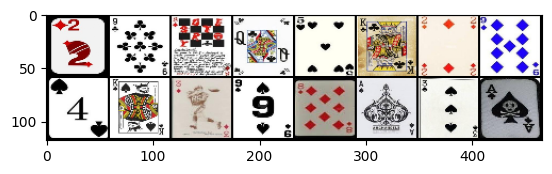

two of diamonds nine of clubs eight of diamonds queen of clubs five of hearts king of clubs two of diamonds nine of diamonds four of spades king of spades three of diamonds nine of spades eight of diamonds ace of spades three of spades ace of spades


In [ ]:

import torchvision
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{class_names[labels[j]]:5s}' for j in range(batch_sz)))

### Define a CNN
#### Generate a CNN for the classification task in the cell below. You may either use an existing network (ResNet18, VGG11, etc.) and modify it as needed, or build your own network from scratch.

In [ ]:
import torch.nn as nn
import torch.optim as optim
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, padding=2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, padding=2)

        # Linear layers
        self.fc1 = nn.Linear(32 * 14* 14, 120)
        self.fc2 = nn.Linear(120, 53)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 32 * 14* 14)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return nn.functional.log_softmax(x, dim=1)

In [ ]:
model = Net()
summary(model,(3,56,56))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 56, 56]           1,216
         MaxPool2d-2           [-1, 16, 28, 28]               0
            Conv2d-3           [-1, 32, 28, 28]          12,832
         MaxPool2d-4           [-1, 32, 14, 14]               0
            Linear-5                  [-1, 120]         752,760
            Linear-6                   [-1, 53]           6,413
Total params: 773,221
Trainable params: 773,221
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.04
Forward/backward pass size (MB): 0.72
Params size (MB): 2.95
Estimated Total Size (MB): 3.70
----------------------------------------------------------------


## Loss
#### Define Loss function in the following cell

In [ ]:
# ADD CODE HERE
loss_f= nn.CrossEntropyLoss()


### Training loop
#### Define an optimizer, write the training loop in the following cell, and plot the loss

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Update the question marks '?' and add code where needed
model = Net().to(device)
num_epochs = 10
lr = 0.1
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.5)

for i in range(num_epochs):
  for batch, (data, target) in enumerate(train_loader):
    # ADD CODE HERE
    # Set up the model and optimizer
        data, target= data.to(device), target.to(device)
        opt.zero_grad()
        output = model(data)
        loss = loss_f(output, target)
        loss.backward()
        opt.step()
        if batch % 100 == 0:
            print('Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                i+1, batch* len(data), len(train_loader.dataset),
                100. * batch / len(train_loader), loss.item()))

<ipython-input-7-0d5000bc3a7a>:15: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im = Image.imread(f'{self.imfol}{self.images[idx]}')


torch.Size([16, 53]) torch.Size([16])
Epoch: 1 [0/7624 (0%)]	Loss: 4.000626
torch.Size([16, 53]) torch.Size([16])
torch.Size([16, 53]) torch.Size([16])
torch.Size([16, 53]) torch.Size([16])
torch.Size([16, 53]) torch.Size([16])
torch.Size([16, 53]) torch.Size([16])
torch.Size([16, 53]) torch.Size([16])
torch.Size([16, 53]) torch.Size([16])
torch.Size([16, 53]) torch.Size([16])
torch.Size([16, 53]) torch.Size([16])
torch.Size([16, 53]) torch.Size([16])
torch.Size([16, 53]) torch.Size([16])
torch.Size([16, 53]) torch.Size([16])
torch.Size([16, 53]) torch.Size([16])
torch.Size([16, 53]) torch.Size([16])
torch.Size([16, 53]) torch.Size([16])
torch.Size([16, 53]) torch.Size([16])
torch.Size([16, 53]) torch.Size([16])
torch.Size([16, 53]) torch.Size([16])
torch.Size([16, 53]) torch.Size([16])
torch.Size([16, 53]) torch.Size([16])
torch.Size([16, 53]) torch.Size([16])
torch.Size([16, 53]) torch.Size([16])
torch.Size([16, 53]) torch.Size([16])
torch.Size([16, 53]) torch.Size([16])
torch.Size([

## Check test accuracy

In [ ]:
# ADD CODE HERE
accuracy=0
for batch in test_loader:
  images,labels=batch
  images, labels=images.to(device), labels.to(device)
  y_hat=nn.functional.softmax(model(images),dim=0)
  n=labels.size(0)
  _, predicted=torch.max(y_hat.data,1)
  accuracy+=torch.sum((predicted==labels))/n

print('accuracy: ', f'{accuracy.item()/len(test_loader)*100:.2f}', '%' )





<ipython-input-7-0d5000bc3a7a>:15: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im = Image.imread(f'{self.imfol}{self.images[idx]}')


accuracy:  59.72 %
